In [16]:
import cv2
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

import os

In [14]:
image_path = "../results/predicted_images/predictions_3/"
img = os.path.join(image_path, "002_3.jpg")

In [19]:
x = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

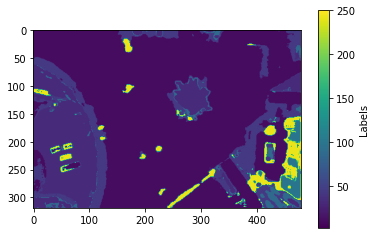

In [23]:
plt.figure()
plt.imshow(x)
plt.colorbar(label="Labels")

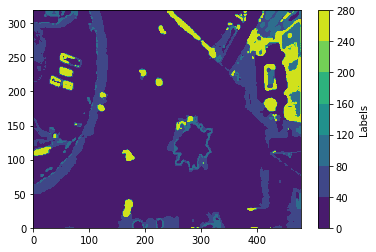

In [27]:
plt.figure()
plt.contourf(x)
plt.colorbar(label="Labels")